In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [ ]:
x = pd.read_csv('X_data.csv',index_col=0)
y_def = pd.read_csv('y_data.csv',index_col=0)
y = y_def['y']

In [ ]:
x.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [ ]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
x_train_raw,x_test_raw,y_train,y_test = train_test_split(x,y,test_size=0.73,random_state=0)

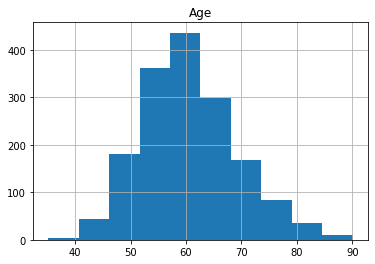

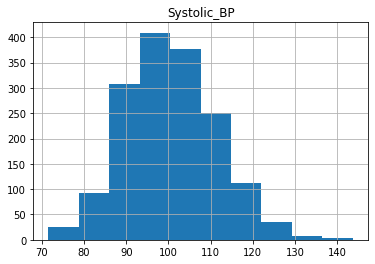

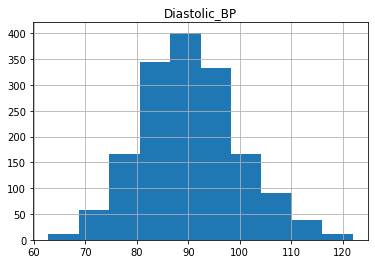

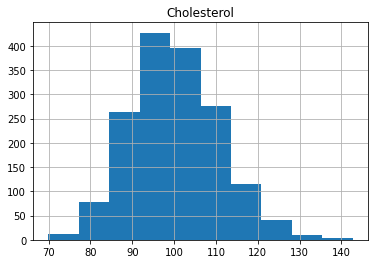

In [ ]:
for col in x.columns:
  x_train_raw.loc[:,col].hist()
  plt.title(col)
  plt.show()

In [ ]:
#remove the skew

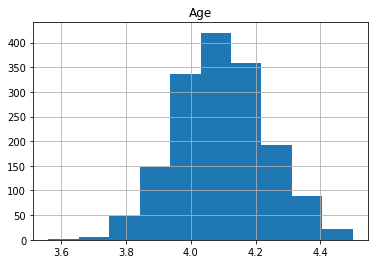

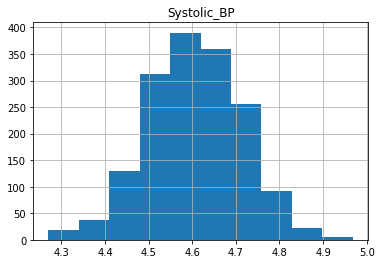

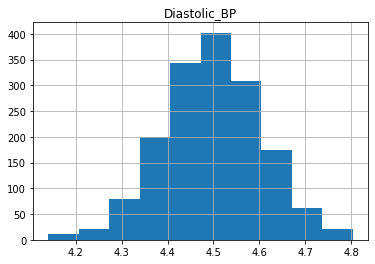

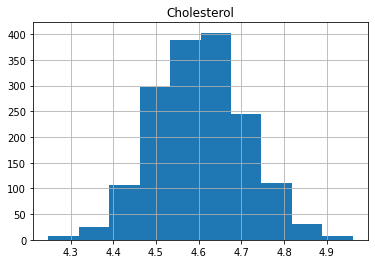

In [ ]:
for col in x_train_raw.columns:
  np.log(x_train_raw.loc[:,col]).hist()
  plt.title(col)
  plt.show()

In [ ]:
def make_standard_normal(df_train,df_test):
  df_train_unskewed = np.log(df_train)
  df_test_unskewed = np.log(df_test)
  mean = df_train_unskewed.mean(axis=0)
  stddev = df_train_unskewed.std(axis=0)
  df_train_standarized = (df_train_unskewed - mean) / stddev
  df_test_standarized = (df_test_unskewed - mean) / stddev
  return df_train_standarized,df_test_standarized

In [ ]:
tmp_train = pd.DataFrame({'field1': [1,2,10], 'field2': [4,5,11]})
tmp_test = pd.DataFrame({'field1': [1,3,10], 'field2': [4,6,11]})
tmp_train_transformed, tmp_test_transformed = make_standard_normal(tmp_train,tmp_test)

print(f"Training set transformed field1 has mean {tmp_train_transformed['field1'].mean(axis=0):.4f} and standard deviation {tmp_train_transformed['field1'].std(axis=0):.4f} ")
print(f"Test set transformed, field1 has mean {tmp_test_transformed['field1'].mean(axis=0):.4f} and standard deviation {tmp_test_transformed['field1'].std(axis=0):.4f}")
print(f"Skew of training set field1 before transformation: {tmp_train['field1'].skew(axis=0):.4f}")
print(f"Skew of training set field1 after transformation: {tmp_train_transformed['field1'].skew(axis=0):.4f}")
print(f"Skew of test set field1 before transformation: {tmp_test['field1'].skew(axis=0):.4f}")
print(f"Skew of test set field1 after transformation: {tmp_test_transformed['field1'].skew(axis=0):.4f}")

Training set transformed field1 has mean -0.0000 and standard deviation 1.0000 
Test set transformed, field1 has mean 0.1144 and standard deviation 0.9749
Skew of training set field1 before transformation: 1.6523
Skew of training set field1 after transformation: 1.0857
Skew of test set field1 before transformation: 1.3896
Skew of test set field1 after transformation: 0.1371


In [ ]:
x_train,x_test = make_standard_normal(x_train_raw,x_test_raw)

In [ ]:
from sklearn.linear_model import LogisticRegression
def lr_model(x_train,y_train):
  model = LogisticRegression()
  model.fit(x_train,y_train)
  return model

In [ ]:
model_x = lr_model(x_train,y_train)

In [ ]:
def cindex(y_true,scores):
  n = len(y_true)
  assert len(scores) == n
  concordant = 0
  permissible = 0 
  ties = 0 
  for i in range(n):
    for j in range(i+1,n):
      if y_true[i] != y_true[j]:
        permissible += 1
        if scores[i] == scores[j]:
          ties += 1
          continue 
        if y_true[i] == 0  and y_true[j] == 1:
          if scores[i] < scores[j]:
            concordant += 1 
        if y_true[j] == 0 and y_true[i] == 1:
          if scores[j] < scores[i]:
            concordant += 1
  c_index = (concordant + (0.5 * ties)) / permissible
  return c_index

In [ ]:
y_true = np.array([1.0, 0.0, 0.0, 1.0])
scores = np.array([0.5, 0.5, 0.0, 1.0])
print('Output: {}'.format(cindex(y_true, scores)))
cindex(y_true, scores)

Output: 0.875


0.875

In [ ]:
scores = model_x.predict_proba(x_test)[:,1]
c_index_x_test = cindex(y_test.values,scores)
print(f"c_index score for test set {c_index_x_test:.4f}")

c_index score for test set 0.8190


In [ ]:
coeffs = pd.DataFrame(data = model_x.coef_,columns=x_train.columns)
coeffs.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,1.107887,0.710707,0.070599,0.573457


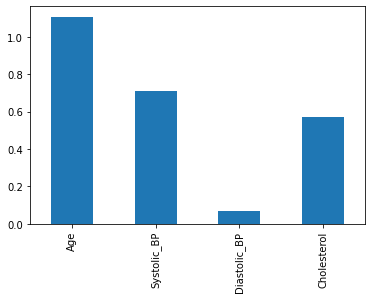

In [ ]:
coeffs.T.plot.bar(legend=None)

In [ ]:
def add_interaction(x):
  features = x.columns
  m = len(features)
  x_int = x.copy(deep=True)
  for i in range(m):
    features_i_name = features[i]
    features_i_data = x.loc[:,features_i_name]
    for j in range(i+1,m):
      features_j_name = features[j]
      features_j_data = x.loc[:,features_j_name]
      features_i_j_name = f"{features_i_name}_x_{features_j_name}"
      x_int[features_i_j_name] = features_i_data * features_j_data
  return x_int


In [ ]:
print("Original Data")
print(x_train.loc[:, ['Age', 'Systolic_BP']].head())
print("Data w/ Interactions")
print(add_interaction(x_train.loc[:, ['Age', 'Systolic_BP']].head()))

Original Data
           Age  Systolic_BP
5305 -0.039921    -1.319661
1188  0.985100    -2.049383
4852 -0.291294    -0.263877
5824 -1.512469    -0.850850
2441 -0.676651     0.368215
Data w/ Interactions
           Age  Systolic_BP  Age_x_Systolic_BP
5305 -0.039921    -1.319661           0.052682
1188  0.985100    -2.049383          -2.018847
4852 -0.291294    -0.263877           0.076866
5824 -1.512469    -0.850850           1.286884
2441 -0.676651     0.368215          -0.249153


In [ ]:
X_train_int = add_interaction(x_train)
X_test_int = add_interaction(x_test)

In [ ]:
model_X_int = lr_model(X_train_int, y_train)

In [ ]:
scores_X = model_x.predict_proba(x_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_x_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8190
c-index on test set with interactions is 0.8289


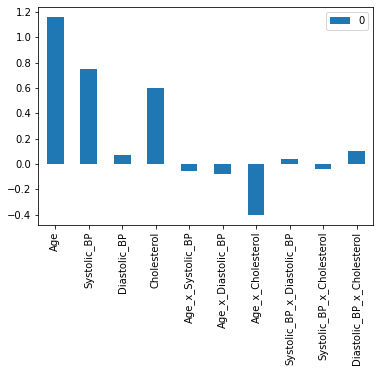

In [ ]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

In [ ]:
index = 343
case = X_train_int.iloc[index, :]
print(case)

Age                           0.072434
Systolic_BP                  -0.121896
Diastolic_BP                 -0.492917
Cholesterol                  -0.638298
Age_x_Systolic_BP            -0.008829
Age_x_Diastolic_BP           -0.035704
Age_x_Cholesterol            -0.046235
Systolic_BP_x_Diastolic_BP    0.060085
Systolic_BP_x_Cholesterol     0.077806
Diastolic_BP_x_Cholesterol    0.314628
Name: 1466, dtype: float64


In [ ]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           0.072434
Systolic_BP                  -0.121896
Diastolic_BP                 -0.492917
Cholesterol                  -0.638298
Age_x_Systolic_BP            -0.008829
Age_x_Diastolic_BP           -0.035704
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.060085
Systolic_BP_x_Cholesterol     0.077806
Diastolic_BP_x_Cholesterol    0.314628
Name: 1466, dtype: float64

In [ ]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.4003
Output without interaction: 	0.3958
